## 编程基础(Keras函数式API编程)

本项目中所有代码都通过Tensorflow2.x实现，所以熟悉Tensorflow的基础操作，以及tf2中keras的使用(与早期的keras的使用基本上是一致的)，对于TF及keras的基础这里不做太多的介绍，大家可以参考相关的资料进行学习。这里主要说一下**keras函数式编程的基本用法**。

keras搭建模型主要有两种模式，一种是**Sequential API**，另外一种是**Functional API**。**前者**主要是通过层的有序堆叠形成一个模型，在大多数情况下**可以快速的搭建一个模型**，**但是搭建的模型更适合简单的堆叠模型**，对于复杂模型(多输入、多输出、共享层)的搭建就比较困难，所以**后者函数式API可以更加灵活的搭建复杂网络**，函数式API搭建模型是通过**创建层的实例并将将层与层之间连接在一起**，最后只需要指定模型的输入和输出就可以完成模型的搭建，不同层的实例可以表示不同的操作，搭建模型的时候只需要考虑层与层之间的关系，以及复杂层的搭建就可以很方便的搭建起一个复杂网络。

**回顾Sequential API搭建模型：**

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# 定义一个3层的序列模型
model = keras.Sequential(
    [
        layers.Dense(2, activation="relu", name="layer1"),
        layers.Dense(3, activation="relu", name="layer2"),
        layers.Dense(4, name="layer3"),
    ]
)

# 与上述的搭建的模型效果是一致的
# model = keras.Sequential(name="my_sequential")
# model.add(layers.Dense(2, activation="relu", name="layer1"))
# model.add(layers.Dense(3, activation="relu", name="layer2"))
# model.add(layers.Dense(4, name="layer3"))

# 定义数据
x = tf.random.normal((3, 4))
y = model(x)

可以看到上述搭建网络直接使用keras中的层直接堆叠即可，但是函数式API与其不太一样，**首先需要定义模型的输入层Input(), 并在Input层中指定输入的数据的维度** ，如下定义一个输入层，输入数据的维度是784, **不需要考虑数据的Batch size维度**，定义的输入层可以认为是数据在模型所表示的层，**接下来就是要将数据进行相应的转换，也就是将输入层输入到下一个层中，将数据进行转换**, 

In [2]:
from tensorflow.keras.models import Model

In [3]:
# 定义输入层(可以看成数据层)
inputs = keras.Input(shape=(784,))

# 定义模型逻辑层(将输入数据进行转换)
x = layers.Dense(64, activation="relu")(inputs)

# 注意：
# layers.Dense(64, activation="relu")表示的是一个Dense层实例，括号中的参数就是创建Dense实例的参数，将inputs输入到layers.Dense(64, activation="relu")实例中，会自动的调用实例的__call__()方法，这样就把输入和层与层之间的逻辑给确定了

# 所以函数API搭建模型的基本操作就是，将输入数据输入到层的实例中，层对象就会调用该层的call方法完成该层的计算并产生新的输出，接下来再将产生的新的输出输入到下一个层实例中产生新的输出，一直不断的构建层的实例并得到新的输出，进而构建一个复杂的模型。

# 定义输出层，这里其实和其他的层没有区别，只不过是最后认定这一层作为输出层而已
outputs = layers.Dense(10)(x)

# 定义整个模型，通过制定模型的输入和输出，按照前面所说的构建模型的流程，产生最终的模型结构
model = Model(inputs=inputs,outputs=outputs)

上面简单的说明了通过函数式API构建模型的流程，下面再了解一下如何使用函数式API的方式构建**多输入、多输出及共享层**的模型：

例如，如果您正在构建一个按优先级排列客户问题通知单并将其发送到正确部门的系统，那么该模型将有三个输入：

1. 票证的标题（文本输入）

2. 票证的文本正文（文本输入）

3. 用户添加的任何标记（分类输入）

该模型将有两个输出：

1. 优先级得分介于0和1之间（标量sigmoid输出），以及

2. 应处理票证的部门（部门集合上的softmax输出）。

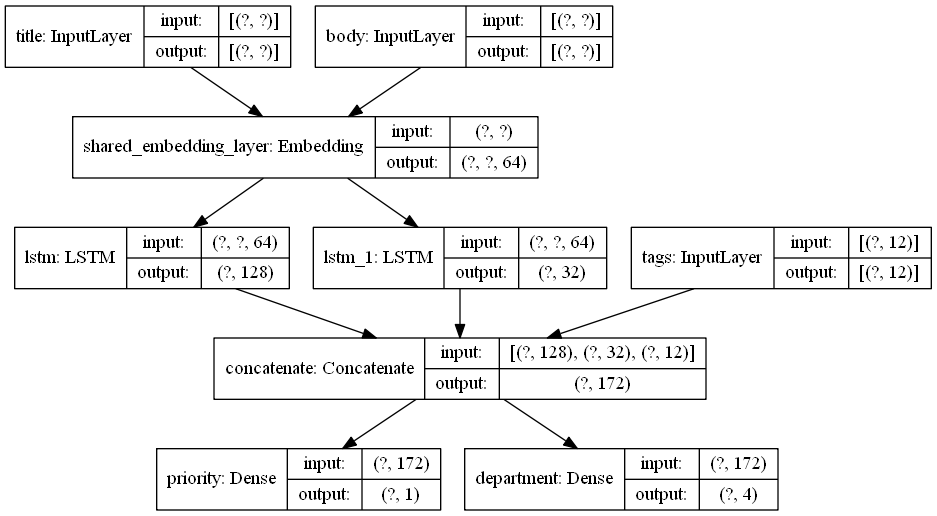

In [4]:
num_tags = 12  # 标记数量
num_words = 10000  # 文本的字典大小
num_departments = 4  # 部门数量

# 定义可变长的序列，表示标题
title_input = keras.Input(shape=(None,), name="title")  
# 定义可变长的序列，表示文本正文
body_input = keras.Input(shape=(None,), name="body")  
# 定义tag的输入，是一个onehot编码向量
tags_input = keras.Input(shape=(num_tags,), name="tags") 

# 定义共享层
shared_embedding_layer = layers.Embedding(num_words, 64, name='shared_embedding_layer')
# 将输入的标题中的每个词转换成64维的向量
title_features = shared_embedding_layer(title_input)
# 将输入的正文中的每个词转换成64维的向量
body_features = shared_embedding_layer(body_input)

# # 将输入的标题中的每个词转换成64维的向量
# title_features = layers.Embedding(num_words, 64)(title_input)
# # 将输入的正文中的每个词转换成64维的向量
# body_features = layers.Embedding(num_words, 64)(body_input)

# 使用LSTM将标题序列转换成一个128维的向量
title_features = layers.LSTM(128)(title_features)
# 使用LSTM将正文序列转换成一个32维的向量
body_features = layers.LSTM(32)(body_features)

# 将多个特征进行拼接
x = layers.concatenate([title_features, body_features, tags_input])

# 将拼接后的特征转换成输出后的单值表示优先级
priority_pred = layers.Dense(1, name="priority")(x)

# 将拼接后的特征转换成一个向量，表示每个部门的概率(这里不是严格的概率，因为没有softmax),
department_pred = layers.Dense(num_departments, name="department")(x)

# 构建多输入，多输出模型
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)

# 画模型结构图
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

从上面这个图就可以看出，模型多输入，多输出，共享层的结构，并且也会发现搭建的过程也是非常的简单。

上面的代码参考的是[Keras官网案例](https://keras.io/guides/functional_api/#shared-layers)，在原始案例的基础上加上了共享层，省的重新再去写一个案例

==当**特征比较多的时候如何构建多输入模型呢？**==

先说答案：**将输入的数据转换成字典的形式**，定义输入层的时候让输入层的name和字典中特征的key一致，就可以使得输入的数据和对应的Input层对应，后面搭建模型就是和上面介绍的一样的了。

<img src="http://ryluo.oss-cn-chengdu.aliyuncs.com/图片image-20210226175546548.png" alt="image-20210226175546548" style="zoom: 50%;" />

直接看个例子吧：

In [5]:
from keras.models import Model
from keras.layers import *
from keras.utils import plot_model
import numpy as np

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
f1 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
f2 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
f3 (InputLayer)                 [(None, 1)]          0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 3)            0           f1[0][0]                         
                                                                 f2[0][0]              

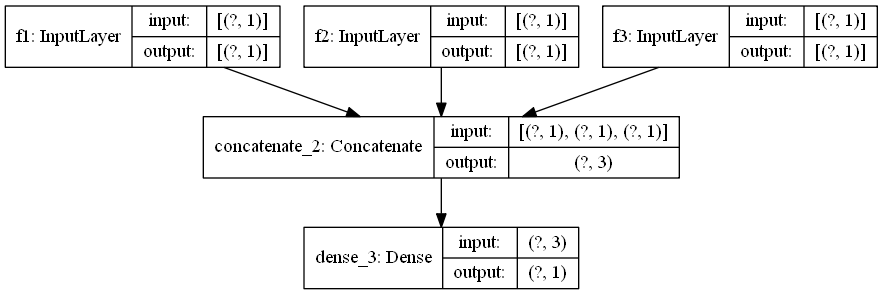

In [9]:
from keras.models import Model
from keras.layers import *
from keras.utils import plot_model
import numpy as np

# 定义三维特征
x = {'f1': np.random.random((5,1)), 
   'f2': np.random.random((5,1)),
   'f3': np.random.random((5,1))}

y = np.array([0, 1, 0, 1, 1])

# 定义输入层：这里层的名称和特征的名称是相同的，所以在模型训练的时候直接输入这个
# 字典形式的数据就可以
inputs = [Input(shape=(1, ), name=key) for key, _ in x.items()]

# 将多个输入拼接之后，在经过一个Dense层输出
concat_feat = Concatenate(axis=1)(inputs)

# 将输入特征映射成1维
output = Dense(1, activation='sigmoid')(concat_feat)

# 构建模型
model = Model(inputs, output)

model.summary()

# 编译模型
model.compile(optimizer='adam', loss='binary_crossentropy', metrics='acc')

# 模型训练和验证
model.fit(x, y, batch_size=1, epochs=2, validation_split=0.2)

# 将模型的结构画出来
keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)

上面就是举了个简单的例子说明，**当多输入特别多的时候，构建模型我们可以将数据转换成字典的形式，然后字典中特征的名称与其对应的Input层的名称一致就行，这里是为了后面搭建复杂模型打基础**。

## 统一视角看推荐模型

相信大家对DeepCTR开源项目应该是有点了解，DeepCTR通过对现有的基于深度学习的点击率预测模型的结构进行抽象总结，在设计过程中采用模块化的思路，各个模块自身具有高复用性，各个模块之间互相独立。 基于深度学习的点击率预测模型按模型内部组件的功能可以划分成以下4个模块：输入模块，嵌入模块，特征提取模块，预测输出模块。关于DeepCTR的介绍可以参考这个文章[DeepCTR：易用可扩展的深度学习点击率预测算法包](https://zhuanlan.zhihu.com/p/53231955)

<img src="http://ryluo.oss-cn-chengdu.aliyuncs.com/图片image-20210221193056946.png" alt="image-20210221193056946" style="zoom:50%;" />

这个开源项目做的非常好反而不是特别适合初学者学习，但是又非常适合推荐系统领域的小白去学习，所以本次内容设计我们借鉴了DeepCTR的设计思想，复现课程中的代码，复现的代码中包含了大量的注释，使得学习者在了解了上述所说的函数式API构建模型的基础上，快速看懂源码的设计，以及模型的原理。下面主要说一下我们代码参考DeepCTR项目实现需要注意的几个点。

==特征表示的统一==

看过DeepCTR源码的人可能就会知道，项目中输入分成三大类，分别是SparseFeat, DenseFeat, VarLenSparseFeat，并且使用类进行了封装，其中也考虑到效率的问题做了一些优化，这里不说具体的类的实现及优化是什么，我先来思考一下使用这三类特征可以表示大多数推荐场景下的特征嘛？

- SparseFeat: 稀疏特征的标记，一般是用来表示id类特征

- DenseFeat: 表示数值型特征，可以是一维的也可以是多维的

- VarLenSparseFeat:  可变长的id类特征，就是id序列特征

这三类特征在实际的推荐系统应用中**包含了绝大多数的特征类型**，在石塔西大佬的[推荐算法的"五环之歌"](https://zhuanlan.zhihu.com/p/336643635)中也说到，**类别特征才是推荐系统中的一等公民，也就是说大部分的特征都是类别特征**，也可能会有一些其他的比如图像、视频等其它特征，虽然实际存不存在，但是我感觉如果要是用这些特征就需要将其转换成向量的形式去使用，也就是DenseFeat多维度的情况。

那么有了这三个统一的标志有什么用呢？答案是用来更好的构建输入层！

==通过特征标记构造输入层==

在前面的函数式API构建模型最后说到过，可以使用字典的形式构建输入，最后只要将对应Input层的名字与字典中特征的key相对应就可以。在定义Input层的时候，除了name以外还有一个重要的属性就是shape

然而所有特征Input层的shape其实只有4种情况：

1. 数值特征，1维的数值特征shape=(1, )
2. 多维的数值特征shape=(dimension, )
3. 类别特征，shape=(1,), 为什么类别特征的shape维度是1呢，因为输入的就是一个id，在类别型特征的Input后面还需要**接一个Embedding层，将id转化成稠密的向量**
4. 可变长的序列特征，shape=(maxlen, 1), 序列的输入往往需要定义一个最大长度，这样不至于序列长度之间相差太大，这个最大长度可以是实际数据中的最大长度，也可以是根据经验定义的最大长度。需要注意的是，序列特征中的每个元素其实也是一个id类特征，在最后转换成Embedding的时候，不是一个Embedding向量，而是一个矩阵。

**上面说了Input层的四种情况有什么用呢？**

当特征维度特别多的时候，比如成百上千维特征，如果没有这种标记的话，我们就需要挨个定义每个特征对应的Input层，当然有人可能会说可以提前分组然后再给不同的Input层，其实本质上是一样的。

==Embedding层的注意点==

在构建模型的时候Embedding相关的需要注意两点：

1. Embedding层的参数问题
2. Embedding层之间的拼接问题

上面在说了类别特征和可变长的序列特征，在这两个Input层之后都需要将其转化成Embedding向量或者Embedding矩阵，在keras中转化成Embedding向量和Embedding矩阵只是相差一个参数的问题

<img src="http://ryluo.oss-cn-chengdu.aliyuncs.com/图片image-20210226191552184.png" alt="image-20210226191552184" style="zoom:67%;" />



==如何在linear层引入onehot特征==

如果要将类别型特征的onehot表示输入到linear层中，第一个想法就是直接把特征转换成onehot向量不就行了吗？的确是可以，但是我们知道在推荐场景中id类特征是一等公民，在实际的场景中如果将所有的特征都转换成onehot类型，维度很可能超出想象。**这里有个更好的做法就是，给id类特征转换成一个一维的Embedding矩阵，只需要将这个Embedding保存下来**，然后有id类特征输入直接在Embedding中进行查找，找到那个对应的值其实就是onehot向量已经乘完权重的值，因为onehot向量只有0和1，只有非零的才是有效的，而1乘以权重还是权重本身，所**以这种方式来获取onehot向量中的非零元素的值，相比直接使用onehot向量乘以一个权重更好一些。**